In [17]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

from numpy import genfromtxt
from scipy.stats import multivariate_normal as mnorm
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# Data formatting

Read in data from csv, correct "nan" error, and split into test/train.

In [18]:
raw_data = genfromtxt('TrainingData_Raw.csv', delimiter=',')

# fix nan
raw_data[0,0]=1.0

train_data = np.vstack((raw_data[0:20,:],raw_data[30:50,:],raw_data[60:80,:],raw_data[90:110,:]))
test_data = np.vstack((raw_data[20:30,:],raw_data[50:60,:],raw_data[80:90,:],raw_data[110:120,:]))

# some constants that describe the breakdown of the training data
num_samples = train_data.shape[1]-1
num_chips= 4
num_readings_per_chip = int(train_data.shape[0]/num_chips)

# SVD Time

Take SVD of the TEST data and examine (1) how the singular values vary (tells us which are likely to be "more important") and (b) what the corresponding singular vectors look like, i.e. what information in the time series are the weighting.

*Remember that we must exclude the label when we take the SVD, otherwise the SVD will just use the label to ID points.*

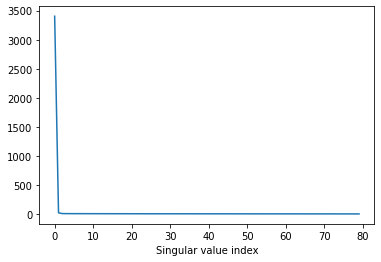

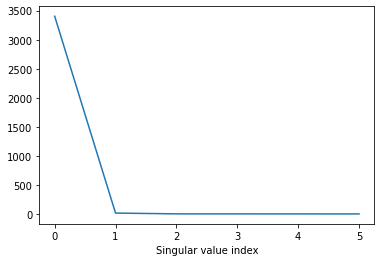

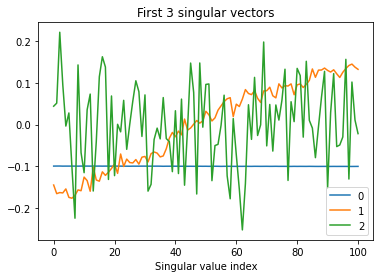

In [43]:
# Take SVD of simulated dataset MINUS the label (first column)
U,Sigma,Vh = np.linalg.svd(train_data[:,1:])

# Look at sing val array
plt.plot(Sigma)
plt.xlabel('Singular value index')
plt.show()

plt.plot(Sigma[:6])
plt.xlabel('Singular value index')
plt.show()

# what do sing vecs do
for sig in range(3):
    plt.plot(Vh[sig,:],label=str(sig))
plt.legend()
plt.title('First 3 singular vectors')
plt.xlabel('Singular value index')
plt.show()


# "Fingerprints"

Given a time series called x, the inner product of x and the rows of Vh (which we defined above) give us "fingerprints" that identify x. We now take the fingerprints of all the training data. Eventually, we'll use these fingerprints to classify test data by asking which set of fingerprints a given test timeseries is "closest" to.

In [20]:
def take_n_fingerprints(train_data,num_fingerprints):
    # We'll compute Vh internally, just to be safe.
    _,_,Vh = np.linalg.svd(train_data[:,1:])
    fingerprints= train_data[:,1:]@Vh[:num_fingerprints,:].T
    
    return fingerprints,Vh

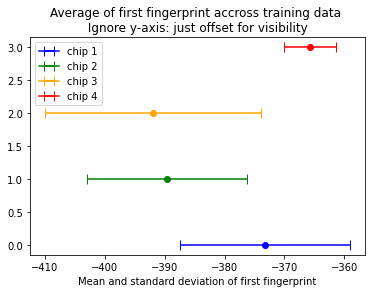

In [21]:
# Examine largest fingerprint
fingerprints,_ = take_n_fingerprints(train_data,1)

colors = ['b','g','orange','r']

# view average 1st fingerprint per chip
for ii in range(num_chips):
    chip_fingerprints = fingerprints[ii*num_readings_per_chip:(ii+1)*num_readings_per_chip,:]
    #print(np.mean(chip_fingerprints,axis=0),'+/-',np.std(chip_fingerprints,axis=0))
    plt.errorbar(np.mean(chip_fingerprints,axis=0),ii,xerr=np.std(chip_fingerprints,axis=0),
                 capsize=5,color=colors[ii],label='chip '+str(ii+1))
    plt.plot(np.mean(chip_fingerprints,axis=0),ii,'o',color=colors[ii])
plt.legend()
plt.title('Average of first fingerprint accross training data \n Ignore y-axis: just offset for visibility ')
plt.xlabel('Mean and standard deviation of first fingerprint')

plt.show()


Plot in 2D using first two fingerprints as coordinates

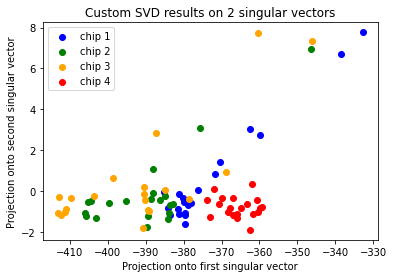

In [42]:
fingerprints,_= take_n_fingerprints(train_data,2)

colors = ['b','g','orange','r']

# view average fingerprint per chip
for ii in range(num_chips):
    chip_fingerprints = fingerprints[ii*num_readings_per_chip:(ii+1)*num_readings_per_chip,:]
    plt.scatter(chip_fingerprints[:,0],chip_fingerprints[:,1],color=colors[ii],label='chip '+str(ii+1))

plt.title('Custom SVD results on 2 singular vectors')
plt.xlabel('Projection onto first singular vector')
plt.ylabel('Projection onto second singular vector')
plt.legend()
plt.show()

Note: as a sanity check, the above plot pretty much matches exactly what we get from calling built-in PCA, which is what we would expect (what we've done above with SVD is essentially equivalent to PCA).

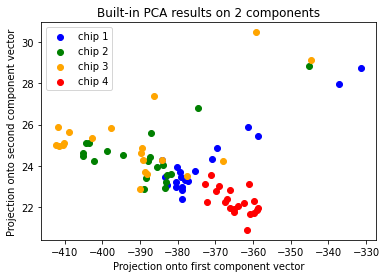

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(train_data[:,1:])
C= pca.components_

# plot PCA coordinates

# compile fingerprints
PCA_fingerprints= train_data[:,1:]@C.T
assert PCA_fingerprints.shape[0] == num_readings_per_chip*num_chips

colors = ['b','g','orange','r']

# view average fingerprint per chip
for ii in range(num_chips):
    chip_fingerprints = PCA_fingerprints[ii*num_readings_per_chip:(ii+1)*num_readings_per_chip,:]
    plt.scatter(chip_fingerprints[:,0],chip_fingerprints[:,1],color=colors[ii],label='chip '+str(ii+1))

    
plt.title('Built-in PCA results on 2 components')
plt.xlabel('Projection onto first component vector')
plt.ylabel('Projection onto second component vector')
plt.legend()
plt.show()
    

# Evaluating prediction performance on test data

We'll model the set of fingerprints from a given chip as a multivariate Gaussian distribution. Then to predict what chip a given test element comes from, we can see which distribution it's "most likely to have been drawn from."

Remember to exclude label. We set rowvar=False because the way our data is formatted, "variables" (i.e. fingerprints) are the columns of our dataset and "observations" (i.e. timeseries/samples) are our rows.

In [24]:
# Compute mean/covariance of the distribution for each chip 
mu_1, cov_1 = np.mean(train_data[:20,1:],axis=0),np.cov(train_data[:20,1:],rowvar=False)
mu_2, cov_2 = np.mean(train_data[20:40,1:],axis=0),np.cov(train_data[20:40,1:],rowvar=False)
mu_3, cov_3 = np.mean(train_data[40:60,1:],axis=0),np.cov(train_data[40:60,1:],rowvar=False)
mu_4, cov_4 = np.mean(train_data[60:80,1:],axis=0),np.cov(train_data[60:80,1:],rowvar=False)

In [27]:
# Returns a tuple: (predicted_ID,true_ID)
def predict_chip_ID(train_data,num_sig_vals,test_sample,verbose = False, return_bool= False):
    fit_scores = list()
    
    fingerprints,Vh = take_n_fingerprints(train_data,num_sig_vals)
    
    # project test point onto rows of Vh
    test_fingerprint = test_sample[1:]@Vh[:num_sig_vals,:].T
    
    # Compute mean/covariance of the distribution for each chip
    for chip_idx in [(0,20),(20,40),(40,60),(60,80)]:
        chip_fingerprints = fingerprints[chip_idx[0]:chip_idx[1],:]
        mu, covariance = np.mean(chip_fingerprints,axis=0),np.cov(chip_fingerprints,rowvar=False)
        fit_scores.append(mnorm.pdf(test_fingerprint,mean=mu,cov=covariance,allow_singular=True))

    predicted_ID = np.argmax(fit_scores)+1
    true_ID = int(test_sample[0])
    if verbose:
        # we'll normalize to make it easier to see which chip has the strongest prediction
        fit_scores = np.divide(fit_scores,np.sum(fit_scores))
        print(fit_scores)
        print('predicted ID = ',predicted_ID,' true ID = ',true_ID)
    
    if return_bool:
        return predicted_ID==true_ID
    return (predicted_ID,true_ID)

def assess_performance(train_data,num_sig_vals,test_data):
    
    is_prediction_correct = [predict_chip_ID(train_data,num_sig_vals,test_sample = test_data[idx,:],
                                            verbose=False,return_bool=True) for idx in range(test_data.shape[0])]
    
    # raw counts: for all test points, what fraction of the time does predicted ID match true ID?
    print('Overall accuracy: ',np.sum(is_prediction_correct)/test_data.shape[0])
    # print('Warning: per-chip accuracy readings uses hardcoded indices. If you edit the composition of test_data, may no longer be accurate.')
    for chip_num,chip_idx in enumerate([(0,10),(10,20),(20,30),(30,40)]):
        print('Accuracy for chip '+str(chip_num+1)+': ',np.sum(is_prediction_correct[chip_idx[0]:chip_idx[1]])/10.0)
        
        # false positive rate = # chips incorrectly ID'd as this chip/ (# chips incorrectly ID'd as this chip+# chips correctly ID'd as NOT being this chip)
        
        # false negative rate = # chips that are actually chip_idx were inccorrectly predicted to have a different ID
    
    predictions = [predict_chip_ID(train_data,num_sig_vals,test_sample = test_data[idx,:],
                                            verbose=False,return_bool=False) for idx in range(test_data.shape[0])]
    y_pred = [tup[0] for tup in predictions]
    y_true = [tup[1] for tup in predictions]
        
    print('Rows correspond to true labels, Columns correspond to predicted labels.')
    cm = confusion_matrix(y_true, y_pred)
    labels=np.array(['chip 1','chip 2','chip 3','chip 4'])
    disp = ConfusionMatrixDisplay(cm,display_labels=labels)
    disp.plot()
        

Changing the number of singular values used impacts performance. Currently we're weighting all the fingerprints equally when we assess the Gaussian fitting process, even though we know that actually only the first few fingerprints contain the bulk of the information/are far more important that the others.

Overall accuracy:  0.825
Accuracy for chip 1:  0.9
Accuracy for chip 2:  0.6
Accuracy for chip 3:  1.0
Accuracy for chip 4:  0.8
Rows correspond to true labels, Columns correspond to predicted labels.


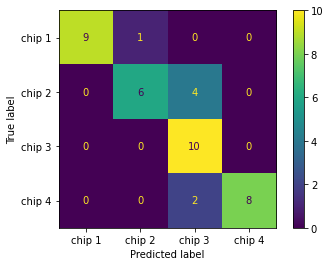

In [37]:
num_sing_vals = 3
assess_performance(train_data,num_sing_vals,test_data)